# Homework 10

In this homework, you will implement NN using PyTorch and investigate different activation functions, batch sizes, and learning rates. Use [Lecture code](https://github.com/anton-selitskiy/RIT_ML/blob/main/2024_spring/Lectures/ML23.ipynb) as refference.

Use load_planar_dataset function from the previous homework to create the data.

In [282]:
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.nn import BCELoss
from torch.optim import Adam
from mlxtend.plotting import plot_decision_regions


In [283]:
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros(m, dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius. 4 corresponds to the number of petals
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    return X, Y

In [284]:
x, y = load_planar_dataset()
y = y.reshape(-1,1)
# x = x.reshape(-1,1)
x.shape, y.shape

((400, 2), (400, 1))

##1. (2 pt) Create Dataset object.

In [285]:
class MyData(Dataset):
  def __init__(self, x, y):
    super().__init__()
    self.x = x
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, index):
    return torch.tensor(self.x[index], dtype = torch.float), torch.tensor(self.y[index], dtype = torch.float)

data = MyData(x,y)
data[2]

(tensor([ 0.0952, -1.2800]), tensor([0.]))

## 2. (1 pt) Create DataLoader object.

In [286]:
data_loader = DataLoader(data, batch_size=10)

In [287]:
for x_batch, y_batch in data_loader:
  print(x_batch.shape, y_batch.shape)
  break

torch.Size([10, 2]) torch.Size([10, 1])


## 3. (3 pt) Construct the model
$$
hidden\_1 \to activation\_1 \to hidden\_2 \to activation\_2  
$$
Use `Sigmoid` function as activation on this step.

In [288]:
class MyModel(nn.Module):
  def __init__(self, hidden_size):
    super().__init__()
    self.fc1 = nn.Linear(2, hidden_size)
    self.activ = nn.Sigmoid()
    self.activ_leak = nn.LeakyReLU()
    self.fc2 = nn.Linear(hidden_size, 1)

  def forward(self, x_batch):
    o = self.fc1(x_batch)
    o = self.activ(o)
    o = self.fc2(o)
    return self.activ(o)

In [289]:
model = MyModel(5)

## 4. (3 pt) Write the training loop. Use Binary cross-entropy loss. Also, you can use tqdm function to see the training progress. You can start with learning rate 0.01.

In [290]:
optimizer = Adam(model.parameters(), lr=0.01)
creterion = BCELoss()

hist = []
for epoch in tqdm(range(100)):
  for x_b, y_b in data_loader:
    y_pred = model.forward(x_b)
    loss = creterion(y_pred, y_b)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    hist.append(loss.item())


100%|██████████| 100/100 [00:05<00:00, 18.30it/s]


## 5. (2 pt) Write the prediction class to use it in plot_decision_regions function.

In [291]:
class PredictionClass():
  def __init__(self, model):
    self.model = model

  def predict(self, x):
    with torch.no_grad():
      y_pred = model.forward(torch.tensor(x, dtype=torch.float))
      return np.where(y_pred >= 0.5, 1, 0)

## 6. (2 pt) Plot the loss and decision boundary after the training.

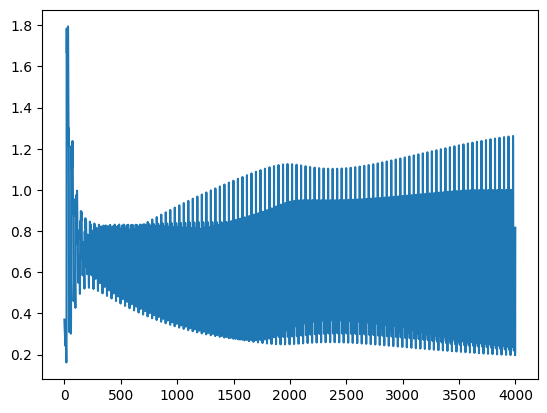

In [292]:
plt.plot(hist)

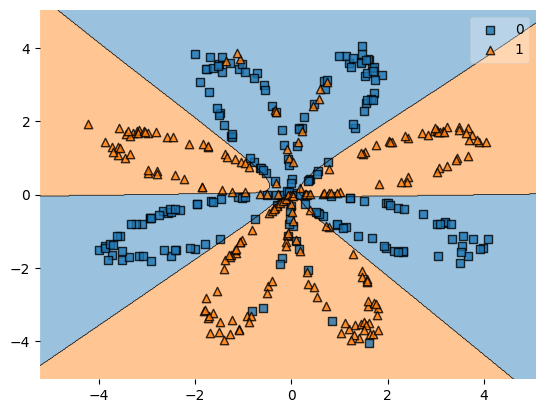

In [293]:
clf = PredictionClass(model)
plot_decision_regions(x,y.reshape(-1,),clf)
plt.show()

## 7. Experiments 1: Try LeakyReLU as `activation_1` with the size of `hidden_1` = 4, 5, and 10. You can reuse the same model without copying it.

In [294]:
hidden_1 = [4, 5, 10]

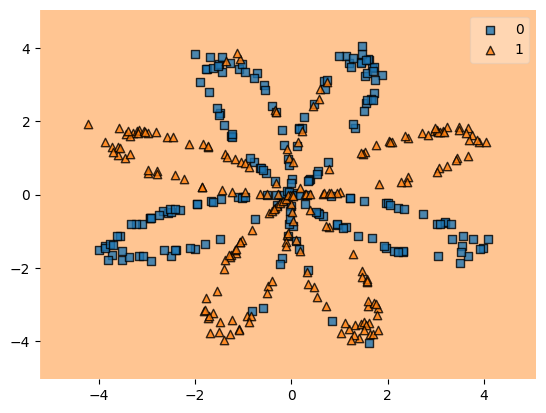

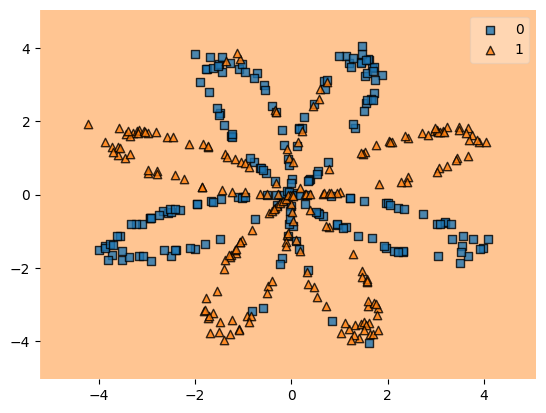

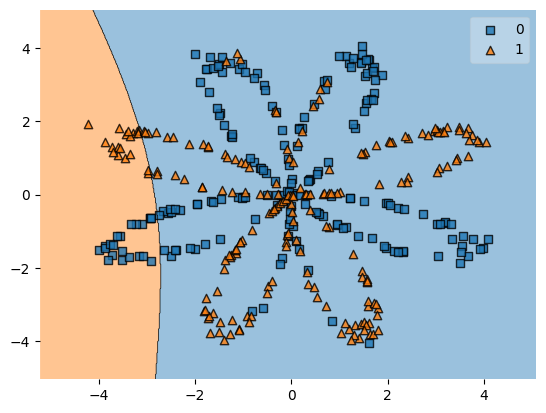

In [295]:
for size in hidden_1:
  model = MyModel(size)
  clf = PredictionClass(model)
  plot_decision_regions(x,y.reshape(-1,),clf)
  plt.show()

## 8. (3 pt) Comment on the number of the straight lines with respect to the size of the hidden layer.

## 9. Experiments 2: with the `hidden_1` layer of the size 4 try Sigmoind, ReLU, LeakyReLU, ELU, and SiLU as `activation_1`. Do this for batch sizes 4 and 50.

## 10. (4 pt) Comment on the shape of the decision boundaries with respect to the activation function and the batch size. Did you adjust the learning rate? Did you try to start with small learning rate like 0.001 instead of 0.01 and if so, which worked better?